In [4]:
!pip install gpxpy contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 55.6 MB/s eta 0:00:00


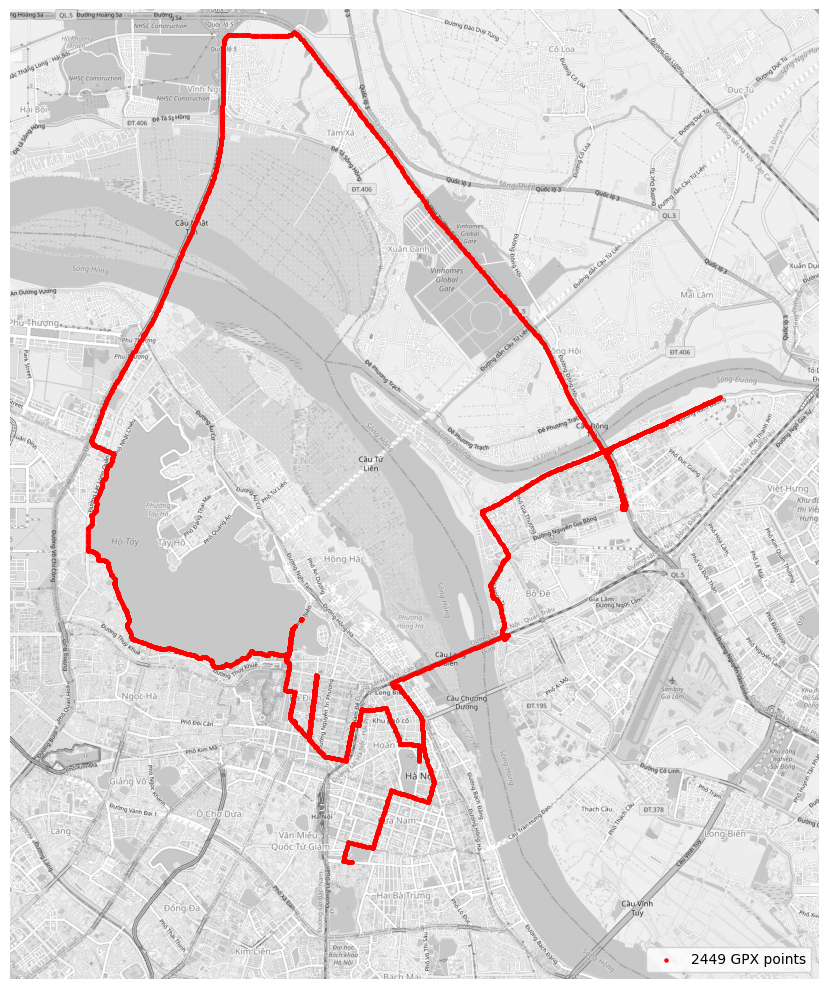

In [8]:
import gpxpy
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from PIL import Image
import numpy as np

# --- Load GPX file ---
gpx_file = "/content/marathon.gpx"  # Change to your GPX filename
with open(gpx_file, 'r') as f:
    gpx = gpxpy.parse(f)

# Extract points
points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append((point.longitude, point.latitude))

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy([p[0] for p in points], [p[1] for p in points]),
    crs="EPSG:4326"
).to_crs(epsg=3857)  # Web Mercator projection

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 10))

# Plot GPX points in red
gdf.plot(ax=ax, color='red', markersize=5,
         label=f"{len(points)} GPX points")

# --- Add grayscale OSM basemap ---
# Fetch tiles first
xmin, ymin, xmax, ymax = gdf.total_bounds
img, ext = ctx.bounds2img(xmin, ymin, xmax, ymax,
                          zoom=14, source=ctx.providers.OpenStreetMap.Mapnik)

# Convert to grayscale
gray_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])  # RGB → Gray

# Show grayscale image as basemap
ax.imshow(gray_img, extent=ext, origin="upper", cmap="gray")

# Overlay points again (to be on top)
gdf.plot(ax=ax, color='red', markersize=5)

# --- Styling ---
ax.legend(loc='lower right')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [17]:
import gpxpy
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString, Point
import numpy as np

# --- Load GPX file ---
gpx_file = "/content/marathon.gpx"
with open(gpx_file, 'r') as f:
    gpx = gpxpy.parse(f)

# Extract all coordinates
points = [(p.longitude, p.latitude)
          for track in gpx.tracks
          for seg in track.segments
          for p in seg.points]

print(f"Original points: {len(points)}")

# --- Convert to GeoDataFrame ---
gdf = gpd.GeoDataFrame(
    geometry=[Point(x, y) for x, y in points],
    crs="EPSG:4326"
).to_crs(epsg=3857)

# --- Create LineString for simplification ---
line = LineString(gdf.geometry.tolist())

# --- Prepare simplification steps ---
targets = [500, 300, 200, 100, 50, 40, 30, 10, 5]

# --- Get bounds for consistent basemap ---
xmin, ymin, xmax, ymax = gdf.total_bounds
img, ext = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=14, source=ctx.providers.OpenStreetMap.Mapnik)
gray_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

# --- Simplify and plot each version ---
for target_points in targets:
    tolerance = 1
    simplified = line

    # Gradually increase tolerance until we hit roughly the target number of points
    while len(simplified.coords) > target_points and tolerance < 1e6:
        tolerance *= 1.5
        simplified = line.simplify(tolerance, preserve_topology=False)

    # Compute distance (in km)
    distance_km = simplified.length / 1000.0

    print(f"Simplified to {len(simplified.coords)} points for target {target_points} "
          f"(tolerance={tolerance:.2f}, distance={distance_km:.2f} km)")

    # Convert simplified points to GeoDataFrame
    simp_gdf = gpd.GeoDataFrame(
        geometry=[Point(x, y) for x, y in simplified.coords],
        crs="EPSG:3857"
    )

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(gray_img, extent=ext, origin="upper", cmap="gray")
    gpd.GeoSeries(simplified).plot(ax=ax, color='red', linewidth=2)
    simp_gdf.plot(ax=ax, color='red', markersize=25,
                  label=f"{len(simplified.coords)} pts | {distance_km:.2f} km | tol={tolerance:.2f}")
    ax.legend(loc='lower right')
    ax.set_title(f"Simplified to ~{target_points} points", fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.